# Reading and Plotting Images

Digital images are, at their core, just large arrays of numbers. While powerful packages like `Images.jl` provide a comprehensive suite of tools, it's incredibly valuable for a mathematical programmer to understand the underlying data structure.

In this section, we'll focus on representing images as numerical arrays and writing our own functions to load and display them. This "from scratch" approach helps reveal the algorithms behind common image processing tasks.

We'll start by defining some utility functions. These will help us read image files into arrays and plot them efficiently in the notebook.

In [1]:
using Plots  # For all our plotting needs
Base.showable(::MIME"image/svg+xml", ::Plots.Plot) = false  # Disable SVG

using FileIO # For loading image files (like .png, .jpg)

# Converts an image loaded by FileIO (which is typically an
# array of `RGB` objects) into a 3D `Float32` array.
# The dimensions will be (height, width, 3).
# The 3rd dimension corresponds to the :r, :g, :b channels.
to3Darray(img) = Float32[ getfield(pxl, fld) for pxl in img, fld in (:r,:g,:b) ]

# The reverse of `to3Darray`.
# Converts our (height, width, 3) numerical array back into an
# array of `RGB` objects, which `Plots.jl` knows how to display as an image.
# `eachslice` creates views for R, G, and B, and `...` (splatting)
# passes them as separate arguments to the `RGB` constructor.
toRGBarray(img) = RGB.(eachslice(img[:,:,:], dims=3)...)

# Our custom 'imread' function:
# 1. `load(filename)`: Use FileIO to read the image file.
# 2. `to3Darray(...)`: Convert it to our standard 3D Float32 array format.
imread(filename) = to3Darray(load(filename))

# Our custom 'imshow' function:
# 1. `toRGBarray(img)`: Convert our 3D array to an `RGB` array.
# 2. `plot(...)`: Use the standard `plot` function.
# We add some sensible defaults for image plotting:
# `aspect_ratio=:equal` (no stretching) and `axis=nothing` (no axes).
imshow(img; args...) = plot(toRGBarray(img); aspect_ratio=:equal, axis=nothing, border=:none, args...)

imshow (generic function with 1 method)

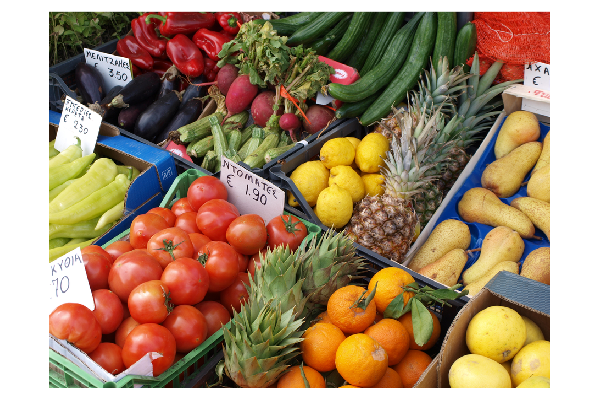

In [2]:
# Load the sample image using our new function.
# 'A' is now a 3D (height, width, 3) array.
A = imread("sample_photo.png")

# Display the image using our 'imshow' wrapper.
imshow(A)

Now that `A` is loaded, let's inspect it as we would any other Julia array. We can use standard functions like `typeof`, `size`, `minimum`, and `maximum` to understand its structure and content.

In [3]:
println("A is of type $(typeof(A)) with dimensions $(size(A))")
println("The values of A range between $(minimum(A)) and $(maximum(A))")

A is of type Array{Float32, 3} with dimensions (684, 912, 3)
The values of A range between 0.0 and 1.0


The output confirms our setup:
* The first two dimensions are the **height** (rows) and **width** (columns) of the image in pixels.
* The third dimension, with a length of 3, represents the **color channels**: Red, Green, and Blue (RGB).

So, `A[y, x, 1]` is the **Red** value for the pixel at row `y`, column `x`. `A[y, x, 2]` is the **Green** value, and `A[y, x, 3]` is the **Blue** value.

### A Note on Data Types: `Float32` vs. `UInt8`

Our `imread` function converts the pixel values to `Float32` numbers ranging from 0.0 (no intensity) to 1.0 (full intensity). This is very convenient for mathematical operations (like scaling, averaging, or linear algebra).

It's important to know that most image files (like PNGs or JPEGs) actually store these values as 8-bit unsigned integers (`UInt8`), which are whole numbers from 0 to 255. Our loader handles this conversion for us (e.g., $255 \rightarrow 1.0$, $128 \rightarrow \approx 0.5$, $0 \rightarrow 0.0$). For this course, we'll stick to the `Float32` representation to simplify the math.

## Isolating Color Channels

To visualize how these three channels (Red, Green, and Blue) combine to create the final image, we can create new images that *only* contain the data from one channel at a time. 

We'll do this by making a copy of `A` and setting the values of the other two channels to 0.0 (which corresponds to black).

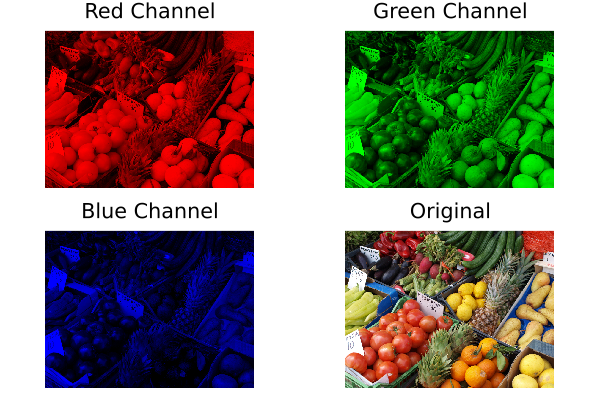

In [4]:
# Create a copy to hold the Red-only image
Ar = copy(A)
# Set the Green (channel 2) and Blue (channel 3) to 0.0
Ar[:,:,[2,3]] .= 0.0

# Create a copy to hold the Green-only image
Ag = copy(A)
# Set the Red (channel 1) and Blue (channel 3) to 0.0
Ag[:,:,[1,3]] .= 0.0

# Create a copy to hold the Blue-only image
Ab = copy(A)
# Set the Red (channel 1) and Green (channel 2) to 0.0
Ab[:,:,[1,2]] .= 0.0

# Create an array of plots
# Note the `.` in `imshow.` - this is broadcasting the function
# over the tuple of images.
plts = imshow.((Ar, Ag, Ab, A))

# Arrange all 4 plots in a 2x2 grid.
# We can pass titles as a 1x4 array to label the subplots.
plot(plts..., layout=(2,2), title=["Red Channel" "Green Channel" "Blue Channel" "Original"])

## Converting to Grayscale

Many image processing algorithms (like edge detection or blurring) are much simpler to define on 2D arrays (one value per pixel) than on 3D (RGB) arrays. To do this, we first need to convert our color image into a **grayscale** (black and white) image.

A simple and common way to do this is to calculate the average *intensity* across the three color channels for each pixel. The result will be a 2D array (or a 3D array with one channel) containing a single intensity value for each pixel.

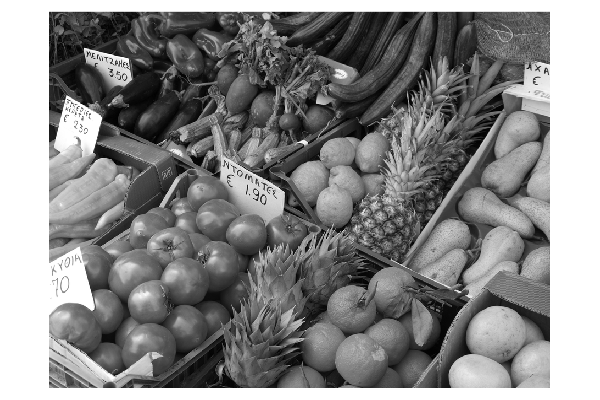

In [5]:
# To average across the 3rd dimension (the color channels):
# 1. `sum(A, dims=3)`: Sums A along dimension 3 (R+G+B for each pixel).
#    This produces a (height, width, 1) array.
# 2. `/ 3`: We divide by 3 to get the average intensity.
B = sum(A, dims=3) / 3

# We can display this (height, width, 1) array.
# Our `toRGBarray` function will cleverly interpret this as a
# grayscale image by setting R, G, and B to the same intensity value
# (e.g., intensity 0.5 becomes RGB(0.5, 0.5, 0.5)).
imshow(B)

## Thresholding and Binary Images

Another common operation is to create a **binary image**: an image with only two values, typically 0 (black) and 1 (white). This is often done by **thresholding** a grayscale image.

We can define a function that takes an array `A` and a threshold value `th`. Every pixel with an intensity *greater than* `th` will become 1.0 (white), and all others will become 0.0 (black).

We'll also demonstrate how to **invert** an image. For a grayscale image with values $x$ between 0 and 1, the inverted value is simply $1-x$. This operation swaps black and white.

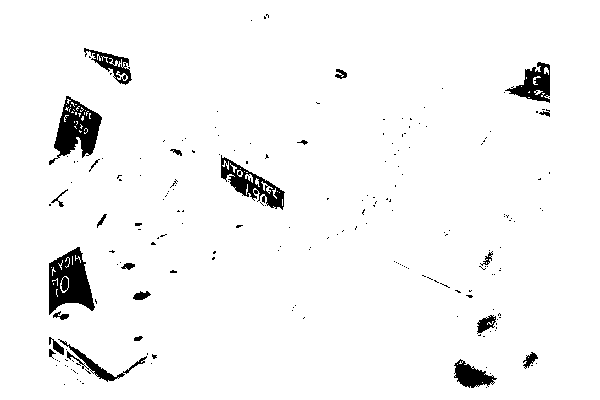

In [6]:
# A function to threshold an image.
# `A .> th` creates a BitArray (boolean) of `true`/`false` values.
# `Float64.(...)` converts `true` to 1.0 and `false` to 0.0.
image_threshold(A, th) = Float64.(A .> th)

# Let's try it on our grayscale image B with a high threshold (0.8).
# This will select only the brightest parts of the image (pixels > 0.8).
binary_img = image_threshold(B, 0.8)

# Now, let's invert it using the 1-x operation.
# This will make the bright spots (1.0) black (0.0) and everything else (0.0) white (1.0).
# `1.0 .- ...` uses broadcasting for element-wise subtraction.
inverted_binary_img = 1.0 .- binary_img

# Display the final inverted, binary image
imshow(inverted_binary_img)